In [1]:
] activate "C:/Users/Arman Angaji/OneDrive - Universität zu Köln/Dokumente/Uni-Köln/Masterarbeit/Workspace/Julia_Master/MasterProject_Julia"

 Activating environment at `C:\Users\Arman Angaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`


In [2]:
using StaticArrays, Distributions, DataFrames, StatsBase, Plots, ProgressMeter, Statistics, Random

## "integrated wt size" distribution

In [3]:
function neutral_growth(endsize; b , d, μ, t= 0. )

    n = 1
    ndist = [1]
    times = [0.]

    while 0 < n < endsize

        p = rand()*(b+d)
        t += rand(Exponential(1.))/((b+d)*n)

        if p > d
            if rand() > μ
                n += 1
            end
        else
            n -= 1
        end
        push!(ndist, n)
        push!(times, t)
    end
    return n, ndist, times
end

neutral_growth (generic function with 1 method)

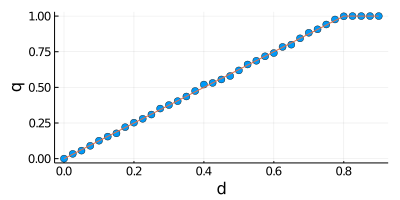

In [9]:
let reps = 4000
    b, μ = 1., 0.2
    drange = 0.:0.025:0.9
    q = similar(collect(drange))
    for (i,d)=enumerate(drange)
        for _=1:reps
            q[i] += iszero(neutral_growth(500; b = b, d = d, μ = μ)[1])
        end
    end
    q ./= reps
    scatter(drange, q, legend=:none, xlab=:d, ylab=:q, size=(400,200))
    plot!(drange, [min(1., d/(b*(1-μ))) for d in drange])
end

haplotype extinction prob is q = d / (b*(1-μ))

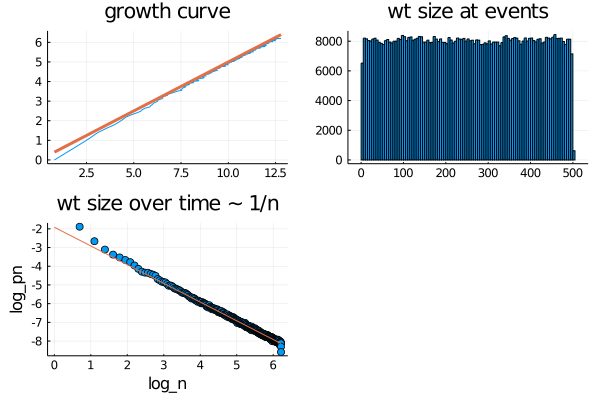

In [7]:
let reps = 1000
    b, d, μ = 1., 0.3, 0.2
    ndist = Array{Array{Int,1}}(undef, reps)
    times = Array{Array{Float64,1}}(undef, reps)
    for i=1:reps
        out = neutral_growth(500; b = b, d = d, μ = μ)
        ndist[i] = out[2]
        times[i] = out[3]
    end

    # 1) wt/haplotype growth curve
    timesmean = [mean(vcat(times...)[findall(isequal(n), vcat(ndist...))])  for n in 1:500]
    p1 = plot(timesmean, log.(1:500), legend=:none, title="growth curve")
    plot!(timesmean, t -> (b*(1-μ)-d)*t, lw=3.)

    # 2) wt/haplotype sizes at eventtimes
    p2 = histogram(vcat(ndist...), title="wt size at events", lab="")
    
    # 3) wt/haplotype sizes integrated over time
    dtimes = [ts[2:end].-ts[1:end-1] for ts in times]
    pop!.(ndist)
    hist = fit(Histogram, vcat(ndist...), weights(vcat(dtimes...)), nbins=500 )
    p3 = scatter(log.(hist.edges[1][2:end]), log.(hist.weights) .- log(sum(hist.weights)))
    plot!(log.(1:500), logn -> -logn - log(sum(1/n for n=1:500)))
    plot!(legend=:none, xlab=:log_n, ylab=:log_pn, title="wt size over time ~ 1/n" )
    
    plot(p1,p2,p3, layout=3)
end

 - 1) haplotypes grow at rate b*(1-μ) - d
 - 2) the distribution of wt sizes at events (!) is uniform
 - waiting times (between events) on the other hand are ∝ 1/n
 - 3) so wt size integrated over time is ~1/n

## haplotype-parent size at birth

In [12]:
function neutral_growth(endsize; b , d, μ, t= 0. )

    n = 1
    nmut = 0
    ndist = Int[]

    while 0 < n < endsize

        p = rand()*(b+d)
        t += rand(Exponential(1.))/((b+d)*n)
        if p > d
            if rand() < μ
                nmut += 1
                push!(ndist, n)
            else
                n += 1
            end
        else
            n -= 1
        end
    end
    return n, nmut, ndist
end

neutral_growth (generic function with 1 method)

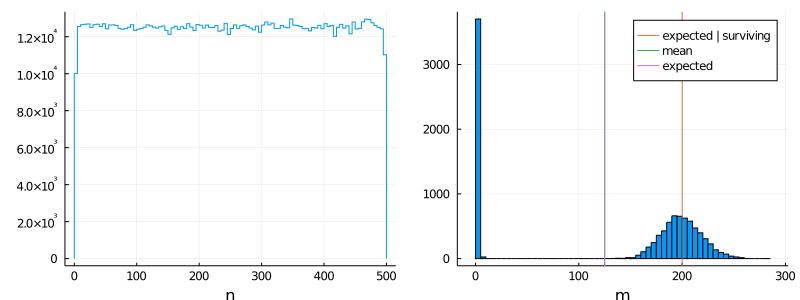

In [15]:

let reps = 10000
    b, d, μ = 1., 0.3, 0.2
    ndist = Array{Array{Int,1}}(undef, reps)
    nmut = Array{Int}(undef, reps)
    for i=1:reps
        out = neutral_growth(500; b = b, d = d, μ = μ)
        ndist[i] =  out[3]
        nmut[i] = out[2]
    end
    p1 = histogram(vcat(ndist...), xlab="n", lab="")

    p2 = histogram(nmut, nbins=100, xlab=:m, lab="")
    vline!([μ*b/(b*(1-μ)-d)*500], lab="expected | surviving")
    vline!([mean(nmut)] , lab="mean")
    vline!([(1-d/(b*(1-μ)))*μ*b/(b*(1-μ)-d)*500  ], lab="expected")
    
    plot(p1, p2, layout=2, size=(800, 300))
end

1) following from wt size distribution: parent (haplotype) size at birth ~ Unif

2)
haplotype growing to size M has $μ\cdot b/λ'\cdot M$ mutants when conditioned on survival

in general: $p(m=0) = (1-q), p(m>0) ~ q\cdot Gaussian(μ\cdot b/λ'\cdot M)$

here λ' is haplotype growth rate b*(1-μ) - d !!

## haplotype turnover - estranged

0.0 0.025 0.05 0.075 0.1 0.125 0.15 0.175 0.2 0.225 0.25 0.275 0.3 0.325 0.35 0.375 0.4 0.425 0.45 0.475 0.5 0.525 0.55 0.575 0.6 0.625 0.65 0.675 0.7 0.725 0.75 0.775 0.8 0.825 0.85 

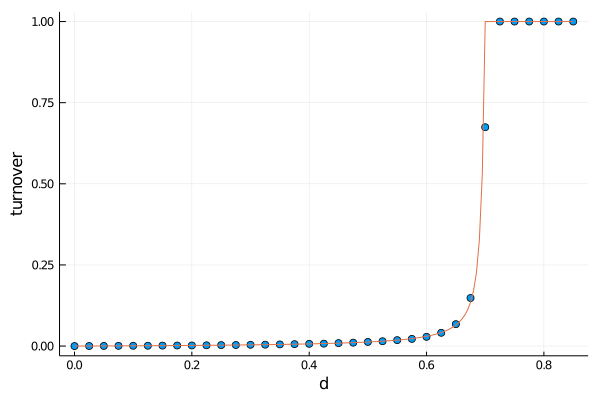

In [17]:
let N = 200
    b , μ = 1., 0.3

    dup = 0.85  # b*(1-μ)
    drange = 0.:0.025:dup
    turnover = similar(collect(drange))

    for (i,d) = enumerate(drange)

        norph = 0
        ntot = 0
        for i=1:10000
            n, nmut, ndist = neutral_growth(N; b = b, d = d, μ = μ)
            norph += iszero(n) ? nmut : 0
            ntot += nmut
        end
        turnover[i] = norph/ntot
        print(d, " ")
    end
    scatter(drange, turnover)

    estim = [ sum( min(1., d/(b*(1-μ)) )^n for n=1:N) / N for d = 0.:0.005:dup]
    plot!( 0.:0.005:dup , estim, legend=:none, xlab=:d, ylab=:turnover)
end

## wt background (clone-ancestor) size at birth

In [3]:
function neutral_growth(endsize; b , d, μ, t= 0. )

    n = 1
    nmut = 0
    ndist = Int[]

    while 0 < n < endsize

        p = rand()*(b+d)
        t += rand(Exponential(1.))/((b+d)*n)
        if p > d
            if rand() < μ
                nmut += 1
                push!(ndist, n)
            end
            n += 1
        else
            n -= 1
        end
    end
    return n, nmut, ndist
end

neutral_growth (generic function with 1 method)

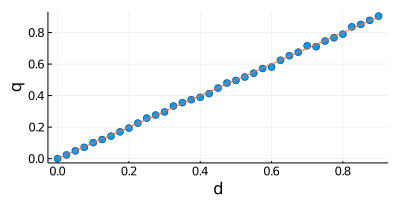

In [4]:
let reps = 4000
    b, μ = 1., 0.2
    drange = 0.:0.025:0.9
    q = similar(collect(drange))
    for (i,d)=enumerate(drange)
        for _=1:reps
            q[i] += iszero(neutral_growth(500; b = b, d = d, μ = μ)[1])
        end
    end
    q ./= reps
    scatter(drange, q, legend=:none, xlab=:d, ylab=:q, size=(400,200))
    plot!(drange, [min(1., d/b) for d in drange])
end

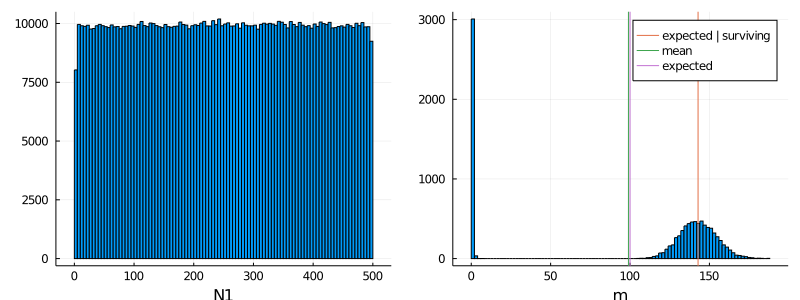

In [21]:
let reps = 10000
    b, d, μ = 1., 0.3, 0.2
    ndist = Array{Array{Int,1}}(undef, reps)
    nmut = Array{Int}(undef, reps)
    for i=1:reps
        out = neutral_growth(500; b = b, d = d, μ = μ)
        ndist[i] = out[3]
        nmut[i] = out[2]
    end
    p1 = histogram(vcat(ndist...), xlab=:N1, lab="")

    p2 = histogram(nmut, nbins=100, xlab=:m, lab="")
    vline!([μ*b/(b-d)*500], lab="expected | surviving")
    vline!([mean(nmut)] , lab="mean")
    vline!([(1-d/b)*μ*b/(b-d)*500  ], lab="expected")
    
    plot(p1, p2, layout = 2, size=(800, 300))
end

1) wt (clone) size at birth is uniform N1 ~ unif

2)
clone growing to size M has μ*β*M mutants when conditioned on survival

in general: p(m=0) = (1-q), p(m>0) ~ q*Gaussian(μ*β*M)

In [3]:
include("neutral_haplotype_growth_v1.jl")
using TumorGrowth: clones_by_mutations, DataFrame

┌ Info: Precompiling TumorGrowth [6c18b9fe-b06a-4315-99c1-34a00b453ec5]
└ @ Base loading.jl:1260


Loading Packages... 

┌ Warning: Package TumorGrowth does not have Distributions in its dependencies:
│ - If you have TumorGrowth checked out for development and have
│   added Distributions as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with TumorGrowth
└ Loading Distributions into TumorGrowth from project dependency, future warnings for TumorGrowth are suppressed.


Done!


d0.0 d0.05 d0.1 d0.15 d0.2 d0.25 d0.3 d0.35 d0.4 d0.45 d0.5 d0.55 d0.6 d0.65 d0.7 d0.75 d0.8 d0.85 d0.9 d0.95 d0.975 

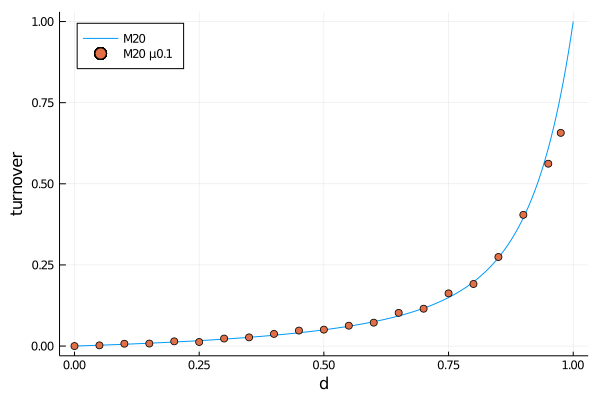

In [16]:
b, μ = 1., 0.1

N, M = 10*20, 20
drange = collect(0.0:0.05:0.95)
push!(drange, 0.975)
reps = 500

countorph = zeros(Float64, length(drange))

for (i,dp)=enumerate(drange)
    q = dp/b
    
    k = 0
    ntot = 0
    for _=1:reps
        out = neutral_growth(N ; Nthresh=M, b = b, d = dp, μ = μ)
        tumor = DataFrame(out[1])
        obs = out[2][:, 2]
        isempty(obs) && continue
        mtypes = clones_by_mutations(tumor)[1]
        freqs = sum.(getproperty.(mtypes,:n))
        filter!(!iszero, freqs)
        isempty(freqs) && continue
        k += 1
        ntot += length(freqs)
        countorph[i] += count(iszero, 1N .- freqs )
    end
    countorph[i] /= ntot
    
    print("d",dp," ")
    sleep(0.1)
end

estim = [ sum( min(1., d/b )^n for n=1:M) / M for d = 0.:0.005:1.]
plot(0.:0.005:1., estim, lab="M$M", legend=:topleft, xlab=:d, ylab=:turnover)
scatter!(drange, countorph, lab="M$M μ$μ")

d0.0 d0.05 d0.1 d0.15 d0.2 d0.25 d0.3 d0.35 d0.4 d0.45 d0.5 d0.55 d0.6 d0.65 d0.7 d0.75 d0.8 d0.85 d0.9 d0.95 

Progress: N  393 	 Time: 0:00:00

d0.975 

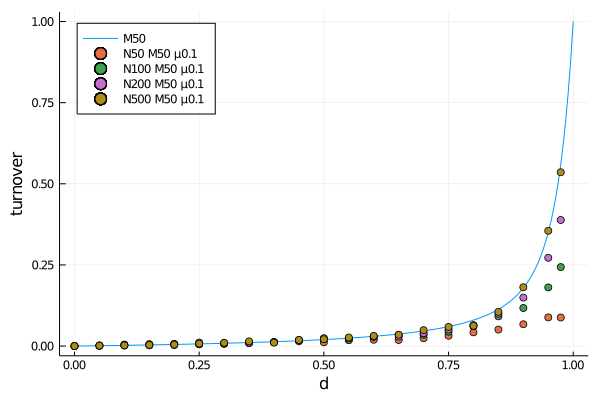

In [11]:
b, μ = 1., 0.1

N, M = 500, 50
drange = collect(0.0:0.05:0.95)
push!(drange, 0.975)
reps = 500

countorph = zeros(Float64, length(drange))

for (i,dp)=enumerate(drange)
    q = dp/b
    
    k = 0
    ntot = 0
    for _=1:reps
        out = neutral_growth(N ; Nthresh=M, b = b, d = dp, μ = μ)
        tumor = DataFrame(out[1])
        obs = out[2][:, 2]
        isempty(obs) && continue
        mtypes = clones_by_mutations(tumor)[1]
        freqs = sum.(getproperty.(mtypes,:n))
        filter!(!iszero, freqs)
        isempty(freqs) && continue
        k += 1
        ntot += length(freqs)
        countorph[i] += count(iszero, 1N .- freqs )
    end
    countorph[i] /= ntot
    
    print("d",dp," ")
    sleep(0.1)
end

estim = [ sum( min(1., d/b )^n for n=1:M) / M for d = 0.:0.005:1.]
# plot(0.:0.005:1., estim, lab="M$M", legend=:topleft, xlab=:d, ylab=:turnover)
scatter!(drange, countorph, lab="N$N M$M μ$μ")

 - simulation matches turnover curve for single curve
 - a cutoff needs to be set on the tumor (i.e. parent clone) size at which new mutants appear in order to make sure the clone (or rather subclones) has enough time to go extinct
 - final size should be about ~8 times higher than cutoff size

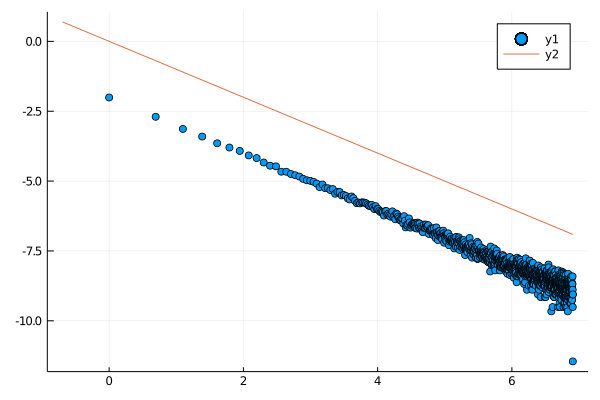

In [23]:
# 1/n size distribution
# this simulation also shows the 1/n distribution of haplotype sizes over time

function subclonegrowth()
    Random.seed!(1234)
    tstep=0.001
    a=1.
    b=.5
    μ = 0.2
    nwtvec=zeros(Int,0)
    for run in 1:10000
        nwt=1
        while 0<nwt<1000
            if rand()<a*tstep*nwt
                if rand() > μ
                    nwt+=1
                end
            end
            if rand()<b*tstep*nwt
                nwt-=1
            end
            if rand()<0.001
                push!(nwtvec,nwt)
            end
        end
    end
    return(nwtvec)
end

ns = subclonegrowth()

hist = fit(Histogram, ns, nbins = maximum(ns))
scatter(log.(hist.edges[1]), log.(hist.weights./sum(hist.weights)) )
plot!(log.(midpoints(hist.edges[1])), logn -> -logn)